In [1]:
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Откройте и изучите файл

In [2]:
data = pd.read_csv('users_behavior.csv')
data.info()
display(data.describe())
display(data.head())

### Визуализация

In [3]:
data['is_ultra_cat'] = data['is_ultra'].replace({
    1: 'Ультра',
    0: 'Смарт'
}).astype('category')

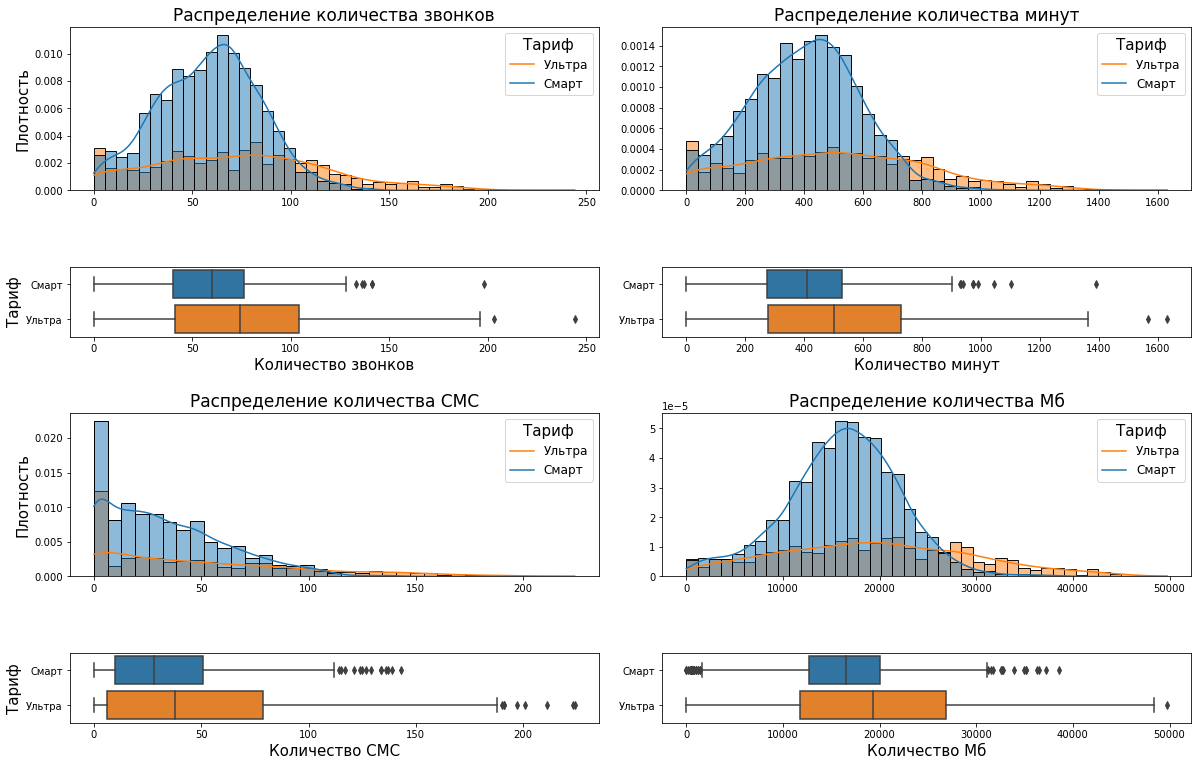

In [4]:
plt.rcParams['figure.figsize'] = (17, 11)
fig, axs = plt.subplots(nrows=4,
                        ncols=2,
                        gridspec_kw={"height_ratios": (.35, .15, 0.35, 0.15)})

# calls
sns.histplot(data=data,
             x='calls',
             hue='is_ultra_cat',
             kde=True,
             stat='density',
             ax=axs[0][0])
sns.boxplot(data=data, x='calls', y='is_ultra_cat', ax=axs[1][0])
# minutes
sns.histplot(data=data,
             x='minutes',
             hue='is_ultra_cat',
             kde=True,
             stat='density',
             ax=axs[0][1])
sns.boxplot(data=data, x='minutes', y='is_ultra_cat', ax=axs[1][1])
# messages
sns.histplot(data=data,
             x='messages',
             hue='is_ultra_cat',
             kde=True,
             stat='density',
             ax=axs[2][0])
sns.boxplot(data=data, x='messages', y='is_ultra_cat', ax=axs[3][0])
# mb_used
sns.histplot(data=data,
             x='mb_used',
             hue='is_ultra_cat',
             kde=True,
             stat='density',
             ax=axs[2][1])
sns.boxplot(data=data, x='mb_used', y='is_ultra_cat', ax=axs[3][1])

# calls
axs[0][0].legend(['Ультра', 'Смарт'], title='Тариф', fontsize='12')
axs[0][0].set_title('Распределение количества звонков', fontsize=17)
axs[0][0].set_ylabel('Плотность', fontsize=15)
axs[0][0].set_xlabel('')
plt.setp(axs[0][0].get_legend().get_title(), fontsize='15')
axs[1][0].set_xlabel('Количество звонков', fontsize=15)
axs[1][0].set_ylabel('Тариф', fontsize=15)
# minutes
axs[0][1].legend(['Ультра', 'Смарт'], title='Тариф', fontsize='12')
axs[0][1].set_title('Распределение количества минут', fontsize=17)
axs[0][1].set_ylabel('')
axs[0][1].set_xlabel('')
plt.setp(axs[0][1].get_legend().get_title(), fontsize='15')
axs[1][1].set_xlabel('Количество минут', fontsize=15)
axs[1][1].set_ylabel('')
# messages
axs[2][0].legend(['Ультра', 'Смарт'], title='Тариф', fontsize='12')
axs[2][0].set_title('Распределение количества СМС', fontsize=17)
axs[2][0].set_ylabel('Плотность', fontsize=15)
axs[2][0].set_xlabel('')
plt.setp(axs[2][0].get_legend().get_title(), fontsize='15')
axs[3][0].set_xlabel('Количество СМС', fontsize=15)
axs[3][0].set_ylabel('Тариф', fontsize=15)
# mb_used
axs[2][1].legend(['Ультра', 'Смарт'], title='Тариф', fontsize='12')
axs[2][1].set_title('Распределение количества Мб', fontsize=17)
axs[2][1].set_ylabel('')
axs[2][1].set_xlabel('')
plt.setp(axs[2][1].get_legend().get_title(), fontsize='15')
axs[3][1].set_xlabel('Количество Мб', fontsize=15)
axs[3][1].set_ylabel('')

plt.tight_layout(pad=2)
plt.show()

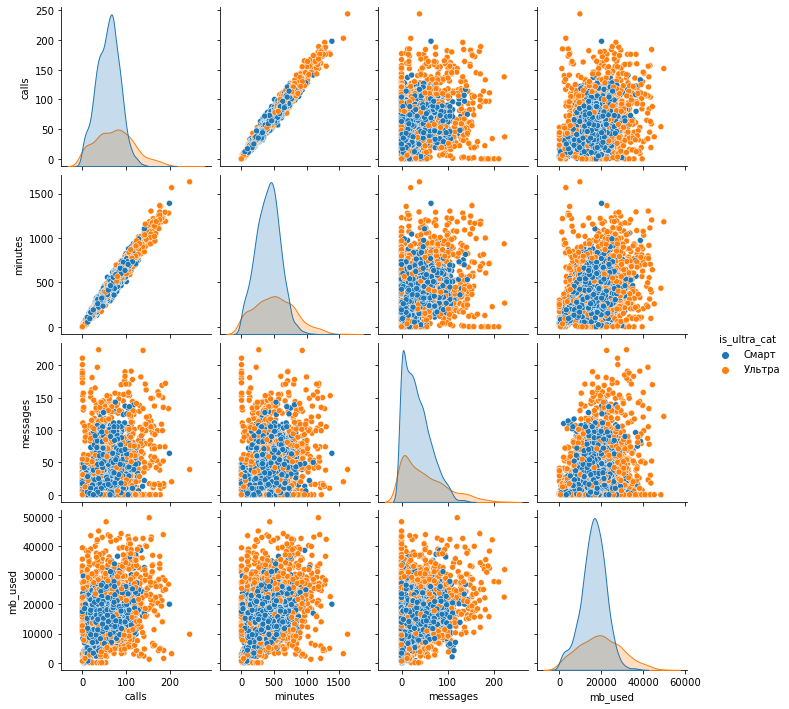

In [5]:
sns.pairplot(data.drop('is_ultra', axis=1), hue='is_ultra_cat');

In [6]:
data.drop('is_ultra_cat', axis=1, inplace=True)

**ВЫВОД:**
Пропусков в данных нет.  
Все данные нужного типа.  
Наблюдается небольшой дисбаланс классов.  
Признаки распределены нормально за исключением `messages`.  
В данных есть выбросы.  
`calls` и `minutes` - мультиколлиниарны.  
Признаки в разных масштабах.

## Разбейте данные на выборки

In [7]:
train, valid_test = train_test_split(data, test_size=0.4, random_state=45)
valid, test = train_test_split(valid_test, test_size=0.5, random_state=45)

train.info()
display(train.describe())
display(train.head(2))

valid.info()
display(valid.describe())
display(valid.head(2))

test.info()
display(test.describe())
display(test.head(2))

**ВЫВОД:**
Данные разбиты на три выборки в соотношении 3:1:1.
Статистики для всех выборок идентичны.

P.S.: Я сделал это просто для галочки. Настраивать модели буду на кросс-валидации.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_ultra',
                                                              axis=1),
                                                    data['is_ultra'],
                                                    test_size=0.25,
                                                    random_state=45)

## Исследуйте модели

In [9]:
result = {
    'model': ['RandomForest', 'LogisticRegression', 'SVM', 'KNN'],
    'train_time': [],
    'cv_accuracy_score': [],
    'predict_time': [],
    'hold_out_accuracy_score': []
}

### Случайный лес

In [10]:
rf = RandomForestClassifier(n_jobs=-1, random_state=45, warm_start=True)

#### Настройка гиперпараметров и обучение

In [11]:
params = {
    'n_estimators': [n for n in range(100, 600, 100)],
    'max_depth': [n for n in range(2, 6)] + [None],
    'min_samples_split': [n for n in range(2, 37, 5)]
}

start_time = time.time()
grid_search = GridSearchCV(rf,
                           param_grid=params,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=True,
                           cv=3)
grid_search.fit(X_train, y_train)
print("Настройка гиперпараметров заняла", (time.time() - start_time) / 60,
      'мин.')

start_time = time.time()
tuned_rf = grid_search.best_estimator_
tuned_rf.fit(X_train, y_train)
result['train_time'].append(time.time() - start_time)
print("Обучение заняло", result['train_time'][0], 'сек.')

print("Лучшие параметры для случайного леса:", grid_search.best_params_)
result['cv_accuracy_score'].append(grid_search.best_score_)
print("Лучшее значение метрики accuracy для случайного леса:",
      result['cv_accuracy_score'][0])

#### Проверка на тестовой выборке

In [12]:
start_time = time.time()
rf_predictions = tuned_rf.predict(X_test)
result['predict_time'].append(time.time() - start_time)
print("Предсказание заняло", result['predict_time'][0], "сек.")

result['hold_out_accuracy_score'].append(accuracy_score(
    y_test, rf_predictions))
print("accuracy случайного леса на тестовой выборке:",
      result['hold_out_accuracy_score'][0])
p_r_f_s = precision_recall_fscore_support(y_test, rf_predictions)
res_rf = pd.DataFrame(p_r_f_s,
                      index=['precision', 'recall', 'f_score', 'support'])
res_rf

### Логистическая регрессия

In [13]:
log_reg = LogisticRegression(penalty='elasticnet',
                             solver='saga',
                             max_iter=500,
                             n_jobs=-1,
                             random_state=45,
                             warm_start=True)

#### Дополнительная предобработка

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_ultra',
                                                              axis=1),
                                                    data['is_ultra'],
                                                    test_size=0.25,
                                                    random_state=45)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Настройка гиперпараметров и обучение

In [15]:
params = {'C': np.logspace(-3, 3), 'l1_ratio': np.linspace(0, 1)}

start_time = time.time()
grid_search = GridSearchCV(log_reg,
                           param_grid=params,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=5,
                           cv=3)
grid_search.fit(X_train, y_train)
print("Настройка гиперпараметров заняла", (time.time() - start_time) / 60,
      'мин.')

start_time = time.time()
tuned_log_reg = grid_search.best_estimator_
tuned_log_reg.fit(X_train, y_train)
result['train_time'].append(time.time() - start_time)
print("Обучение заняло", result['train_time'][1], 'сек.')

print("Лучшие параметры для логистической регрессии:",
      grid_search.best_params_)
result['cv_accuracy_score'].append(grid_search.best_score_)
print("Лучшее значение метрики для логистической регрессии:",
      result['cv_accuracy_score'][1])

#### Проверка на тестовой выборке

In [16]:
start_time = time.time()
log_reg_predictions = tuned_log_reg.predict(X_test)
result['predict_time'].append(time.time() - start_time)
print("Предсказание заняло", result['predict_time'][1], "сек.")

result['hold_out_accuracy_score'].append(
    accuracy_score(y_test, log_reg_predictions))
print("accuracy логистической регрессии на тестовой выборке:",
      result['hold_out_accuracy_score'][1])
p_r_f_s = precision_recall_fscore_support(y_test, log_reg_predictions)
res_log_reg = pd.DataFrame(p_r_f_s,
                           index=['precision', 'recall', 'f_score', 'support'])
res_log_reg

### Метод опорных векторов

In [17]:
svm = SVC()

#### Дополнительная предобработка

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_ultra',
                                                              axis=1),
                                                    data['is_ultra'],
                                                    test_size=0.25,
                                                    random_state=45)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Настройка гиперпараметров и обучение

In [19]:
params = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3]
}

start_time = time.time()
grid_search = GridSearchCV(svm,
                           param_grid=params,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=5,
                           cv=3)
grid_search.fit(X_train, y_train)
print("Настройка гиперпараметров заняла", (time.time() - start_time) / 60,
      'мин.')

start_time = time.time()
tuned_svm = grid_search.best_estimator_
tuned_svm.fit(X_train, y_train)
result['train_time'].append(time.time() - start_time)
print("Обучение заняло", result['train_time'][2], 'сек.')

print("Лучшие параметры для метода опорных векторов:",
      grid_search.best_params_)
result['cv_accuracy_score'].append(grid_search.best_score_)
print("Лучшее значение метрики для метода опорных векторов:",
      result['cv_accuracy_score'][2])

#### Проверка на тестовой выборке

In [20]:
start_time = time.time()
svm_predictions = tuned_svm.predict(X_test)
result['predict_time'].append(time.time() - start_time)
print("Предсказание заняло", result['predict_time'][2], "сек.")

result['hold_out_accuracy_score'].append(
    accuracy_score(y_test, svm_predictions))
print("accuracy метода опорных векторов на тестовой выборке:",
      result['hold_out_accuracy_score'][2])
p_r_f_s = precision_recall_fscore_support(y_test, svm_predictions)
res_svm = pd.DataFrame(p_r_f_s,
                       index=['precision', 'recall', 'f_score', 'support'])
res_svm

### Метод *K* ближайших соседей

In [21]:
knn = KNeighborsClassifier(n_jobs=-1)

#### Дополнительная предобработка

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('is_ultra',
                                                              axis=1),
                                                    data['is_ultra'],
                                                    test_size=0.25,
                                                    random_state=45)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Настройка гиперпараметров и обучение

In [23]:
params = {
    'n_neighbors': [n for n in range(5, 50, 5)],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

start_time = time.time()
grid_search = GridSearchCV(knn,
                           param_grid=params,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=5,
                           cv=3)
grid_search.fit(X_train, y_train)
print("Настройка гиперпараметров заняла", (time.time() - start_time) / 60,
      'мин.')

start_time = time.time()
tuned_knn = grid_search.best_estimator_
tuned_knn.fit(X_train, y_train)
result['train_time'].append(time.time() - start_time)
print("Обучение заняло", result['train_time'][3], 'сек.')

print("Лучшие параметры для метода ближайших соседей:",
      grid_search.best_params_)
result['cv_accuracy_score'].append(grid_search.best_score_)
print("Лучшее значение метрики для метода ближайших соседей:",
      result['cv_accuracy_score'][3])

#### Проверка на тестовой выборке

In [24]:
start_time = time.time()
knn_predictions = tuned_knn.predict(X_test)
result['predict_time'].append(time.time() - start_time)
print("Предсказание заняло", result['predict_time'][3], "сек.")

result['hold_out_accuracy_score'].append(
    accuracy_score(y_test, knn_predictions))
print("accuracy метода ближайших соседей на тестовой выборке:",
      result['hold_out_accuracy_score'][3])
p_r_f_s = precision_recall_fscore_support(y_test, knn_predictions)
res_knn = pd.DataFrame(p_r_f_s,
                       index=['precision', 'recall', 'f_score', 'support'])
res_knn

## Итоги

In [25]:
model_compare_table = pd.DataFrame(result).set_index('model')
model_compare_table

**ВЫВОД:**
Модель Случайного леса является наилучшей по совокупности показателей: наивысшие метрики качества как на кросс-валидации, так и на отложенной тестовой выборке; сравнительно малое время обучения, единственный недостаток - большое время предсказания. Стоит отметить, что настройка гиперпараметров этой модели занимает достаточно много времени, но после того как они настроены, модель на этих данных показывает хорошие результаты.

Также я бы выделил метод *K* ближайших соседей: хорошее качество на кросс-валидации и на тестовой выборке, очень малое время настройки гиперпараметров, обучения и предсказания.

Если бы нужно было выдавать результат в режиме "онлайн", то я бы рекомендовал пожертвовать качеством леса в пользу метрического метода, но поскольку в данной задаче мы не ограничены во времени, необходимо использовать модель с самым большой точностью.

Я предполагаю, что модель логистической регрессии и метод опорных векторов (я возлагал на них большие надежды) показали бы лучший результат, если бы мы применили немного feature engineering. Например, добавили бы нелинейности в задачу, введя полиномиальные признаки.

## (бонус) Проверьте модели на адекватность

Предлагаю в качестве предсказательной модели использовать симметричную монетку: орел - даем клиенту тариф "Смарт", решка - "Ультра".
Сравним с точностью предсказания при помощи моделей машинного обучения.

In [26]:
coin_predictions = [np.random.randint(0, 2) for _ in range(len(y_test))]
print("Точность предсказания при помощи монетки:",
      accuracy_score(y_test, coin_predictions))
p_r_f_s = precision_recall_fscore_support(y_test, coin_predictions)
res_coin = pd.DataFrame(p_r_f_s,
                        index=['precision', 'recall', 'f_score', 'support'])
res_coin

**ВЫВОД:**
Неплохо, монетка, неплохо. Но Лес лучше.

Давайте просто всем выдадим одинаковый тариф "Смарт", потому что он самый популярный.

In [27]:
smart_predictions = [0]*len(y_test)
print("Точность \"умного\" (англ.smart) предсказания:",
      accuracy_score(y_test, smart_predictions))
p_r_f_s = precision_recall_fscore_support(
    y_test, smart_predictions, zero_division=0)
res_smart = pd.DataFrame(
    p_r_f_s, index=['precision', 'recall', 'f_score', 'support'])
res_smart

**ВЫВОД:**
Намного лучше монетки, но хуже моих чудесных моделей!

Из-за дисбаланса классов метрика довольно высокая и может показаться, что предсказание константой - хороший вариант. Этим и плоха метрика `accuracy`: в определенных задачах можно получить великолепный с виду результат порядка 0,9, который на деле ничего не значит.

Таким образом, все обученные модели успешно прошли тест на вменяемость.

## Интерпретируем результаты

In [28]:
rf_feat_imp = pd.DataFrame(tuned_rf.feature_importances_, columns=['importance']).set_index(
    X_train.columns).sort_values(by='importance', ascending=False)
rf_feat_imp

In [29]:
log_reg_feat_imp = pd.DataFrame(tuned_log_reg.coef_[0], columns=['importance']).set_index(
    X_train.columns).sort_values(by='importance', ascending=False)
log_reg_feat_imp

**ВЫВОД:**
Наиболее важным признаком при определении лучшего тарифа для пользователя является количество потраченного интернет-трафика в месяц.
Случайный лес считает количество отправленных СМС наименее важным признаком, в то время как для логистической регрессии эта величина вносит почти такой же вклад, что и интернет трафик.
Важность количества звонков "урезана" регуляризацией линейной модели, потому что в данных есть признак "количество минут разговора". В ходе исследования, проводились эксперименты на данных, в которых был каждый из этих признаков в отдельности, но все-таки с двумя сразу метрика оказалась выше.


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
